概要  
trainフォルダーには、犬と猫の25,000枚の画像が含まれている。  
このフォルダ内の各画像には、ファイル名の一部としてラベルが付いている。  
テストフォルダーには、数値IDに従って名前が付けられた12,500個の画像が含まれている。  
テストセット内の各画像について、画像が犬である確率を予測する必要があります（1 =犬、0 =猫）。  

この問題を解決するために、最後のレイヤーのみを置き換える事前学習済みモデルResNet-50を使用する。

In [1]:
import os, cv2, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from random import shuffle 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
%matplotlib inline 

Using TensorFlow backend.
C:\Users\fx757887\Anaconda3\envs\machine-learning-20200307\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\fx757887\Anaconda3\envs\machine-learning-20200307\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\fx757887\Anaconda3\envs\machine-learning-20200307\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qi

・モデルで使用されるいくつかのパラメーターを設定する。  
　画像サイズは224。
　画像は、trainとtestの2つのフォルダーに保存される。
・犬と猫の2つの画像クラスがある。
　trainデータセットのサブセット（20,000画像）を使用する。
  trainセットの50％がトレーニングに、50％が検証に使用される。
・ResNet-50の事前トレーニングモデルが使用される。
　10エポックの数がトレーニングに使用される。

In [2]:
TEST_SIZE = 0.5
RANDOM_STATE = 2018
BATCH_SIZE = 30#64
NO_EPOCHS = 10
NUM_CLASSES = 2
SAMPLE_SIZE = 20000
PATH = '../Kaggle_DogvsCats/'
TRAIN_FOLDER = PATH+'train/'
TEST_FOLDER =  PATH+'test/'
IMG_SIZE = 224
RESNET_WEIGHTS_PATH = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

・データ確認
　trainの画像リストを設定。
・SAMPLE_SIZE値を設定すると、トレーニングセットのサイズを縮小/拡大できます。
　現在、SAMPLE_SIZEは20,000に設定されています。

In [3]:
train_image_list = os.listdir(TRAIN_FOLDER)[0:SAMPLE_SIZE]
test_image_list = os.listdir(TEST_FOLDER)

・画像名を解析する関数を設定して、画像名から最初の3文字を抽出する。
　これより、画像のラベルを得る。  
  それは猫か犬のどちらかになる。  
・onehotencorderを使用して、猫には[1,0]を、犬には[0,1]を保存しています。

In [4]:
def label_pet_image_one_hot_encoder(img):
    pet = img.split('.')[-3]
    if pet == 'cat': return [1,0]
    elif pet == 'dog': return [0,1]

データを処理する関数（トレインとテストセットの両方）も定義している。

In [5]:
def process_data(data_image_list, DATA_FOLDER, isTrain=True):
    data_df = []
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER,img)
        if(isTrain):
            label = label_pet_image_one_hot_encoder(img)
        else:
            label = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        data_df.append([np.array(img),np.array(label)])
    shuffle(data_df)
    return data_df

データ探索、クラス分布  
猫/犬の分布を確認するために、列車データを調べる。  
最初に、縮小された列車データの分割する。  

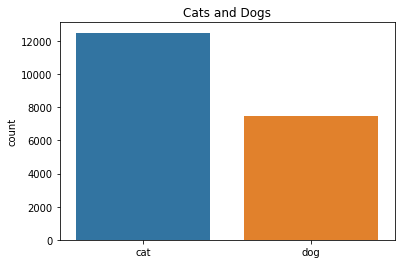

In [6]:
def plot_image_list_count(data_image_list):
    labels = []
    for img in data_image_list:
        labels.append(img.split('.')[-3])
    sns.countplot(labels)
    plt.title('Cats and Dogs')
    
plot_image_list_count(train_image_list)

完全な列車データセットのクラス分布も示す。

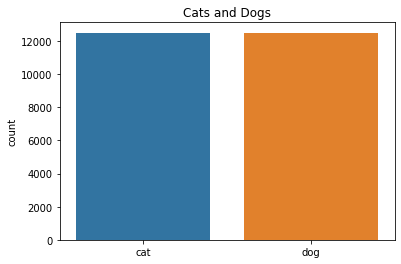

In [7]:
plot_image_list_count(os.listdir(TRAIN_FOLDER))

・画像サンプル  
　いくつかの画像を再表示しましょう。trainセットからの選択から始める。  
　trainセットの最初の25枚の画像を表示する。 
・最初に、trainデータを処理し、画像を読み取り、画像とラベルを含む表を作成する。  
　データがtrainセットの場合、ラベルはnoehotencoderで計算されたものである。  
　データがtestセットからのものである場合、ラベルはイメージ番号になる。  

In [8]:
train = process_data(train_image_list, TRAIN_FOLDER)

100%|██████████| 20000/20000 [00:59<00:00, 333.42it/s]


次に、画像の選択をプロットする。

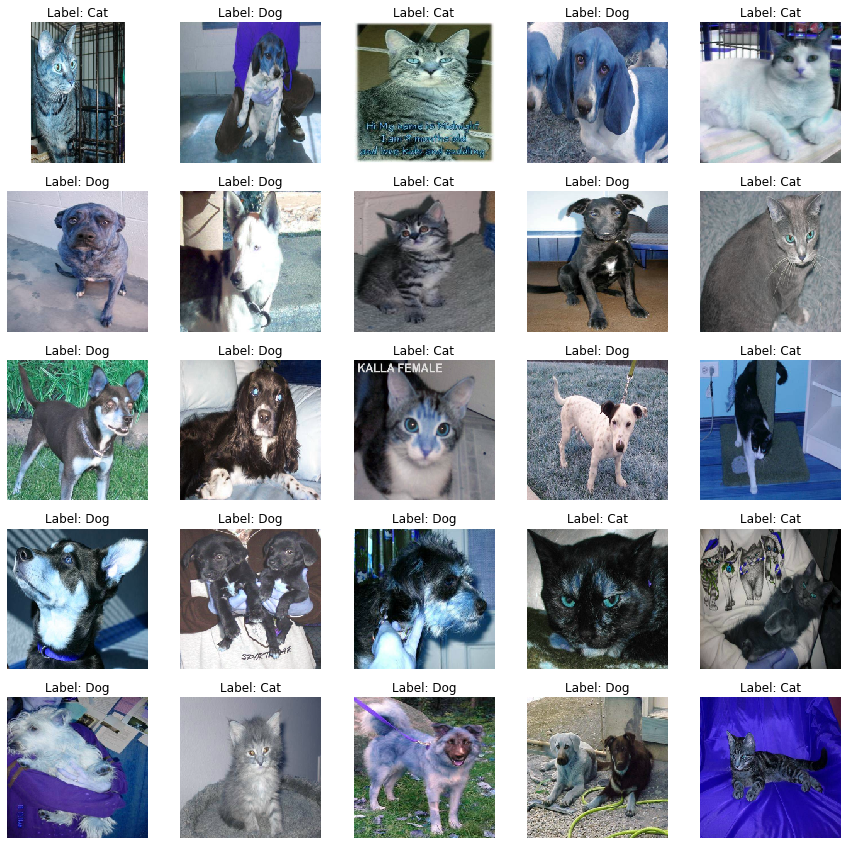

In [9]:
def show_images(data, isTest=False):
    f, ax = plt.subplots(5,5, figsize=(15,15))
    for i,data in enumerate(data[:25]):
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)
        if label  == 1: 
            str_label='Dog'
        elif label == 0: 
            str_label='Cat'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

show_images(train)

trainセットの選択も表示しましょう。testセットを準備する。  

In [10]:
test = process_data(test_image_list, TEST_FOLDER, False)

100%|██████████| 12500/12500 [00:39<00:00, 316.72it/s]


次に、テストセットの選択を示す。

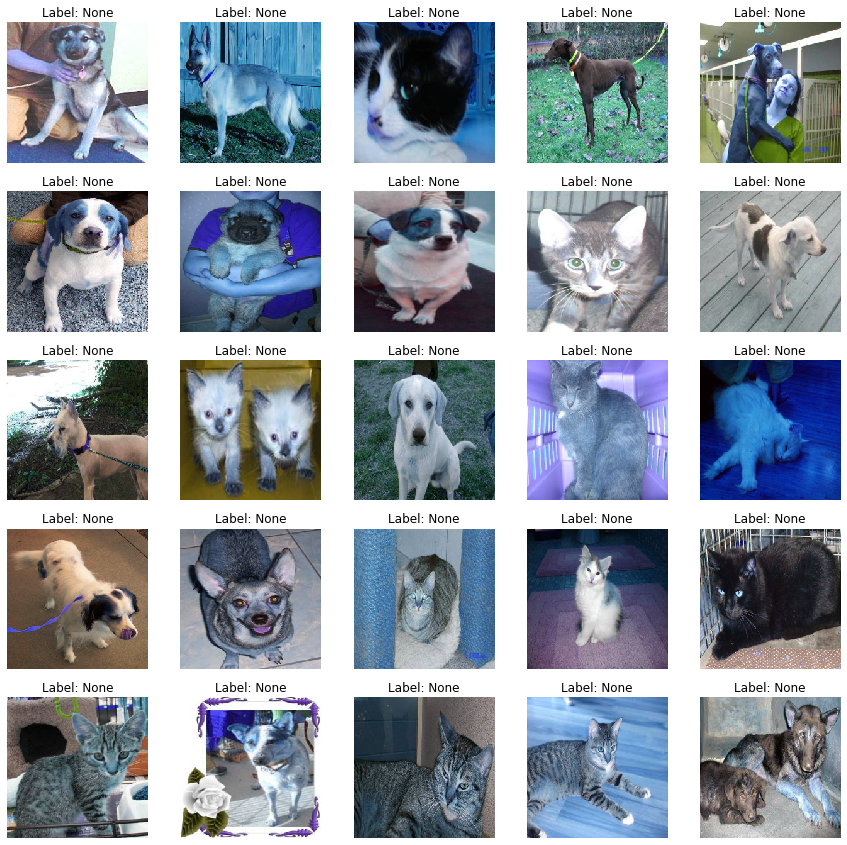

In [11]:
show_images(test,True)

モデルを準備する  

trainデータを準備する

In [12]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train])

モデルを準備する
ResNet-50モデルを初期化し、ソフトマックスアクティベーション機能を使用して、Dense型の最後のレイヤーを追加します。
また、ResNet-50モデルは既にトレーニング済みであるため、モデルの最初のレイヤーをトレーニング不可に設定する。

In [13]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='max', weights=RESNET_WEIGHTS_PATH))
model.add(Dense(NUM_CLASSES, activation='softmax'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


モデルをコンパイルする  
シグモイド最適化、カテゴリークロスエントロピーとしての損失関数、およびメトリック精度を使用して、モデルをコンパイルする。

In [14]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


また、plot_modelを使用してモデルのグラフィカル表現を示す。

#plot_model(model, to_file='model.png')
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

列車と検証の列車データを分割する  
列車データを2つの部分に分割する。　　 
1つはトレインセット用、2つ目は検証セット用に使用する。  
モデルのトレーニングには、データのトレーニングサブセットのみが使用される。  
検証セットは、トレーニング中に検証に使用されます。

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

モデルを訓練する  
これで、モデルをトレーニングする準備ができた。

In [ ]:
train_model=model.fit(X_train, y_train,batch_size=BATCH_SIZE,epochs=NO_EPOCHS,verbose=1,validation_data=(X_val,y_val))

Train on 10000 samples, validate on 10000 samples


検証の精度と損失
同じプロットでトレインと検証の精度を示す。  
同様に、同じグラフでトレインと検証の損失を表す。

In [ ]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['acc']
    val_acc = hist['val_acc']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

数値検証の精度と損失も示す。

In [ ]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

クラスごとの検証精度  
各クラスごとの検証精度を示す  

検証セットのラベルを予測することから始める

In [ ]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_val)
#get the indices to be plotted
y_true = np.argmax(y_val,axis=1)

正しく予測されたクラスと誤って予測されたクラスを使用して、  
検証セット内の画像に対してそれぞれ正しいインデックスと正しくないインデックスを作成する。

In [ ]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

検証セットで正しく予測された値と誤って予測された値の数を確認した。    

ここでは、検証セットの分類レポートを、クラスごとおよび全体の精度とともに示す。

In [ ]:
target_names = ["Class {}:".format(i) for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))


提出物を準備する
予測されたクラスでテスト画像を表示  
予測されたクラスを持つテスト画像のいくつかを示す。このためには、クラスを予測する必要があります。

In [ ]:
f, ax = plt.subplots(5,5, figsize=(15,15))
for i,data in enumerate(test[:25]):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_predicted='Dog'
    else: 
        str_predicted='Cat'
    ax[i//5, i%5].imshow(orig)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(str_predicted))    
plt.show()

テストデータの予測

In [ ]:
pred_list = []
img_list = []
for img in tqdm(test):
    img_data = img[0]
    img_idx = img[1]
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    predicted = model.predict([data])[0]
    img_list.append(img_idx)
    pred_list.append(predicted[1])

提出ファイル　　
提出ファイルを準備する

In [ ]:
submission = pd.DataFrame({'id':img_list , 'label':pred_list})
submission.head()
submission.to_csv("submission2.csv", index=False)


結論
Kerasの事前学習済みモデルResNet-50を使用し、
さらにソフトマックスアクティベーションが追加された高密度モデルと、
少ないセットでトレーニングを行うことで、検証精度の点で非常に優れたモデルを取得できた。

このモデルを使用して、独立したテストセットから画像のクラスを予測し、結果を提出して、新しいデータで予測の精度をテストした。